# Convolutional Neural Networks

## And some practical techniques for training them 

Spencer Bertsch <br>
ENGG 192 <br>
Winter 2019 

In this notebook I explore convolutional networks and use a shallow CNN to classify the MNIST dataset with a ~99% accuracy. The MNIST dataset is a popular dataset used in deep learning becasue it's a comparitively easy problem to solve. Larger, richer datasets with more classes, such as the dataset used to train Alex Net in 2012, are much more difficult to learn and require both more convolutional layers, and a much more robust machine to use for training. 

### Data Source: 

I simply called the mnist.load_data() function to load the MNIST dataset in this notebook. Becasue they're used routinely in image recognition scripts, the MNIST and Iris datasets often come with libraries such as Keras. This makes them easy to work with, and easy to load. The next notebook will use a much larger dataset of color images. 

### Main Sources: 

[Keras-model-training-history](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

[Keras Team - Github](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)


## Imports


In [71]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt 
import time

## Load and shape the dataset 

In [61]:
#Load the dataset 
(x_train, y_train), (x_test, y_test) = mnist.load_data()


data1 = x_train #for visualization
data2 = y_train #for visualization

"""
Our images are greyscale, which means they are two dimensional. We have many image samples, however, so our dataset is three dimensional. 
Our neural netowrk, specifically the 'conv2d' layer, is expecting a four dimensional input for - image samples, [rows, cols] for each image, and the RGB pixel 
value for each pixel in the image. Becasue our images are greyscale, we have a single value for the RGB: intensity (between 0 and 1). Therefor, we need to 
reshape our data to include an additional (1) which will tell our neural network that the image has only one value for each pixel representing intensity. 
We can achieve this by using the below if-else statement. 
"""

if K.image_data_format() == 'channels_first': #<-- checking the Keras backend to determine whether K.image_data_format() is "channels_last" or "channels_first"
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    
print("Shape of original data: ", data1.shape)
print("Shape of reshaped data: ", x_train.shape)

Shape of original data:  (60000, 28, 28)
Shape of reshaped data:  (60000, 28, 28, 1)


LABEL:  0


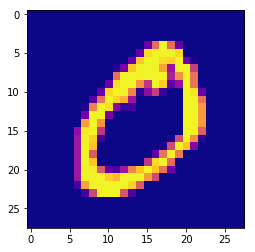

In [62]:
print("LABEL: ", data2[1])
fig = plt.imshow(data1[1, :, :], cmap = plt.cm.plasma);

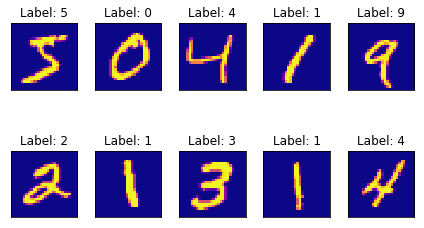

In [88]:
for i in range(10):
    plt.subplot(2,5,1+i)
    plt.title('Label: %d'%data2[i])
    fig = plt.imshow(data1[i, :, :], cmap = plt.cm.plasma);
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
plt.tight_layout()

In [80]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print("We can see that we have",x_train.shape[0], 'train samples')
print("And we have", x_test.shape[0], 'test samples')
print("And each image is", x_test.shape[1], "by", x_test.shape[2] ,'pixels')

x_train shape: (60000, 28, 28, 1)
We can see that we have 60000 train samples
And we have 10000 test samples
And each image is 28 by 28 pixels
Time taken: 0.2001349925994873 seconds


## Define network parameters 

In [65]:
batch_size = 128
num_classes = 10
epochs = 12

## Encode our data 

Use the keras.utils to one-hot encode the label vector. Remember that we are simply recognizing handwritten, single digit numbers so we can tell keras.utils that we want an \[n x 10] matrix with each row containing only one 1 value and the rest 0 values. 

In [66]:
# input image dimensions
img_rows, img_cols = 28, 28

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# Define the network 

--------

We're now ready to define the network with several convolutional, pooling, and dropout layers, ending with a dense, fully connected layer with a softmax activation function which will yeild our final classification. 

In [67]:
#Keras models are generally 'sequential' so we can simply stack layers in tensor flow using the keras API 
model = Sequential()

"""
Our images are greyscale, which means they're 2D, so we can simply use Conv2D and run 4x4 convolutions over the image
Convolutions with different sizes - 3x3 or 5x5 - would also work, but as we increase the size of the convolutions, we 
will begin to lose information for each pass

We use RELU as the activation function. Ever since "Alex Net" was published in 2012, RELu has been the activation function
of choice for convolutional layers in image recognition nets. 
"""


model.add(Conv2D(32, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))
#Convolutional layer 
model.add(Conv2D(64, (3, 3), activation='relu'))
#Max pooling to reduce number of parameter in the model - could have used average pooling 
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout to prevent overfitting 
model.add(Dropout(0.25))

"""
Now that we're done with the convolutional layers and pooling layers to reduce the parameters of the model, we need to flatten the data
and train a dense, fully connected layer on the end of the previous pooling layer. We also use a dropout layer with p=0.5
to prevent overfitting, and finally a last output layer with 10 classes representing each of the classes we are predicting. 

We use the softmax activation function so that we can simply take the maximum value from one of the ten 
"""

#Flatten our model so we can feed the results into a dense neural network 
model.add(Flatten())
#Add dense layer to the flattened output of the last max pooling layer with RELU activation 
model.add(Dense(128, activation='relu'))
#Last dropout layer to prevent overfitting (p = 0.5)
model.add(Dropout(0.5))
#Final dense layer with softmax activation function to predict which of the ten digits is being tested or trained 
model.add(Dense(num_classes, activation='softmax')) #<-- We have 10 classes to predict

"""
Note that there are several hyperparameters noted in this network, and in the above code block where we define 
external network parameters. No explicit hyperparameter optimization was performed here, but by optimizing parameters
such as the p value for the dropout layers, the type of pooling and the pooling size, the kernal size for the convolutional 
layers, the activatin functions (RELU is probably the best to use here, but still good to experiment), and other parameters
such as the overall topology of the network itself would lead to improved network performance. 
"""

## Compile our model

In [68]:
#Here we use categorical_crossentropy as the loss function because we have 10 categories we are trying to predict
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

## Fit the model to the data

In [69]:
#Measure the time it takes to train our model 
tic = time.time()

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

toc = time.time()

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2566 - acc: 0.9210 - val_loss: 0.0530 - val_acc: 0.9812
Epoch 2/12
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0846 - acc: 0.9746 - val_loss: 0.0403 - val_acc: 0.9866
Epoch 3/12
60000/60000 [==============================] - 377s 6ms/step - loss: 0.0653 - acc: 0.9803 - val_loss: 0.0365 - val_acc: 0.9871
Epoch 4/12
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0515 - acc: 0.9842 - val_loss: 0.0296 - val_acc: 0.9905
Epoch 5/12
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0469 - acc: 0.9862 - val_loss: 0.0320 - val_acc: 0.9883
Epoch 6/12
60000/60000 [============

In [85]:
# We can use the 'time' package to measure how long it takes to train the model
print('Time taken to train on ', epochs, 'epochs is:', (toc - tic), 'seconds')

Time taken to train on  12 epochs is: 0.2001349925994873 seconds


# Model Evaluation

--------

In [84]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02323429549929424
Test accuracy: 0.9931


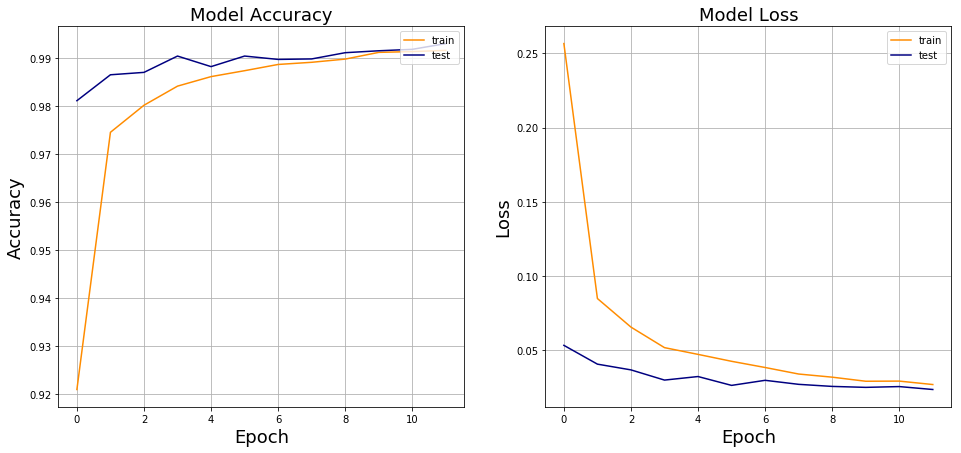

In [70]:
#Plot Accuracy
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121)

plt.plot(history.history['acc'], color='darkorange', label = 'train')
plt.plot(history.history['val_acc'], color='navy', label = 'test')
plt.legend(loc='upper right');
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.title('Model Accuracy', fontsize = 18)
plt.grid()


#Plot Loss
#fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(122)

plt.plot(history.history['loss'], color='darkorange', label = 'train')
plt.plot(history.history['val_loss'], color='navy', label = 'test')
plt.legend(loc='upper right');
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.title('Model Loss', fontsize = 18)
plt.grid()


## Closing remarks

As we can see above, the accuracy achieved on our test set after 12 epochs is 99.31%. This tells us that our network is doing a good job of learning the different spatial aspects of each of the ten hand written numerals. Subsequently, as expected we can see the training and testing loss decresing as we march through our 12 epochs, showing that the neurons in the network are needing to update their weights less and less each time. 

This dataset is a common one for any introduction to convolutional neural networks prpoject for several reasons - one being that this problem (regognizing hand written digits) is a solved problem. For years now, researchers, professors, and students have been able to achieve very high accuracy on this dataset even when training on a CPU such as the one in my laptop. Another reason this dataset is so popular is that the images are greyscale, not color. That means that each pixel is \[1x1] instead of \[1x3] for the RGB values in a color pixel. This makes the convolutions less complicated because they can sweep across the image in 2D, and still effectively achieve a very close approximation to f*(x), the target function. 

In the next notebook, I will use a dataset of color historology images and a deeper convolutional neural network to classify the images with or without the presence of an IDC, or invasive ductal carcinoma. I will also discuss and explore methods for improving model performance for CNNs when working with limited training data including mirroring, scaling, translation, and illumination. 